In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import colorsys
import functools
import math
from abc import ABC, abstractmethod
from collections import Counter, OrderedDict
from typing import Dict, Iterable, List

import matplotlib.pyplot as plt
import numpy as np
import qiskit as qk
import scipy.special as ssp
from matplotlib.colors import LinearSegmentedColormap
from numpy.typing import NDArray
from qiskit.circuit import Qubit
from qiskit.primitives.containers import DataBin
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

import c2qa as bq
from c2qa.primitives import FockSampler

In [3]:
# Some plotting utilities
def gradient_image(ax, direction=0, cmap_range=(0, 1), **kwargs):
    phi = direction * np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]], [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    im = ax.imshow(X, interpolation="bicubic", clim=(0, 1), aspect="auto", **kwargs)
    return im


def gradient_bar(ax, x, y, y2, width=0.5, cmap=plt.cm.Blues_r):
    for left, bottom, top in zip(x, y, y2):
        right = left + width
        gradient_image(
            ax, extent=(left, right, bottom, top), cmap=cmap, cmap_range=(0, 1)
        )

### The Sampler primitive

The `Sampler` and `Estimator` primitives are objects introduced in Qiskit to simplify processing individual shots and calculating expectation values. In this tutorial, we'll focus on the Sampler primitive and how to use the implementation in Bosonic Qiskit, the `FockSampler`, that lightly wraps the underlying Qiskit code to facilitate interpreting classical register values as bosonic energy levels (e.g. $10010_b \rightarrow \ket{18}$).

The main functionality of the Sampler is to return a dict-like `DataBin` object, where the keys correspond to classical register names, and the values are NumPy-like arrays containing the memory (the individual shots, in order) of the measurements. As an example, we consider the state resulting from a controlled-displacement gate
$$\ket{\psi} = \frac{1}{\sqrt{2}}(\ket{0}_Q\ket{0}_B + \ket{1}_Q\ket{\alpha}_B)$$

In [4]:
qubit = qk.QuantumRegister(1, name='qubit')
qumode = bq.QumodeRegister(1, 5, name='qumode')
qubit_creg = qk.ClassicalRegister(1, name="c_qubit")
qumode_creg = qk.ClassicalRegister(5, name="c_qumode")

qc = bq.CVCircuit(qubit, qumode, qubit_creg, qumode_creg)
qc.h(qubit[0])
qc.cv_c_d(0, qumode[0], qubit[0], beta=2)
qc.measure(qubit, qubit_creg)
qc.cv_measure(qumode, qumode_creg)
qc.draw()

┌───┐┌──────────┐┌─┐               
     qubit: ┤ H ├┤5         ├┤M├───────────────
            └───┘│          │└╥┘┌─┐            
  qumode_0: ─────┤0         ├─╫─┤M├────────────
                 │          │ ║ └╥┘┌─┐         
  qumode_1: ─────┤1         ├─╫──╫─┤M├─────────
                 │  Cd(0,2) │ ║  ║ └╥┘┌─┐      
  qumode_2: ─────┤2         ├─╫──╫──╫─┤M├──────
                 │          │ ║  ║  ║ └╥┘┌─┐   
  qumode_3: ─────┤3         ├─╫──╫──╫──╫─┤M├───
                 │          │ ║  ║  ║  ║ └╥┘┌─┐
  qumode_4: ─────┤4         ├─╫──╫──╫──╫──╫─┤M├
                 └──────────┘ ║  ║  ║  ║  ║ └╥┘
 c_qubit: 1/══════════════════╩══╬══╬══╬══╬══╬═
                              0  ║  ║  ║  ║  ║ 
c_qumode: 5/═════════════════════╩══╩══╩══╩══╩═
                                 0  1  2  3  4

To simulate the circuit, we transpile the circuit for the AerSimulator then wrap the AerSampler primitive with the FockSampler.

In [5]:
pm = qk.generate_preset_pass_manager(optimization_level=0, backend=AerSimulator())
qc_isa = pm.run(qc)

sampler = FockSampler.from_sampler(AerSampler(default_shots=2000))
job = sampler.run([qc_isa])
result = job.result()[0] # One result per PUB, in this case we only have one
data = result.data
data

DataBin(c_qubit=BitArray(<shape=(), num_shots=2000, num_bits=1>), c_qumode=FockArray(<shape=(), num_shots=2000>))

As you can see, the resulting `DataBin` has one memory for each classical register. The FockSampler takes care of mapping all binary data for a measured qumode back to integer fock states. We can examine the qubit state, expecting a 50/50 split between the $\ket{0}$ and $\ket{1}$ states:

In [6]:
data.c_qubit.get_counts()

{'0': 994, '1': 1006}

Meanwhile for the qumode, we should see a nice spread over the energy levels

In [7]:
data.c_qumode.get_fock_counts()

{0: 1011,
 4: 201,
 2: 136,
 9: 16,
 8: 39,
 3: 209,
 1: 76,
 7: 55,
 5: 143,
 6: 110,
 10: 2,
 13: 1,
 12: 1}

One of the nice features of the DataBin is the ability to postprocess shots easily. For example, we can split the data up depending on the state of the qubit using NumPy slicing.

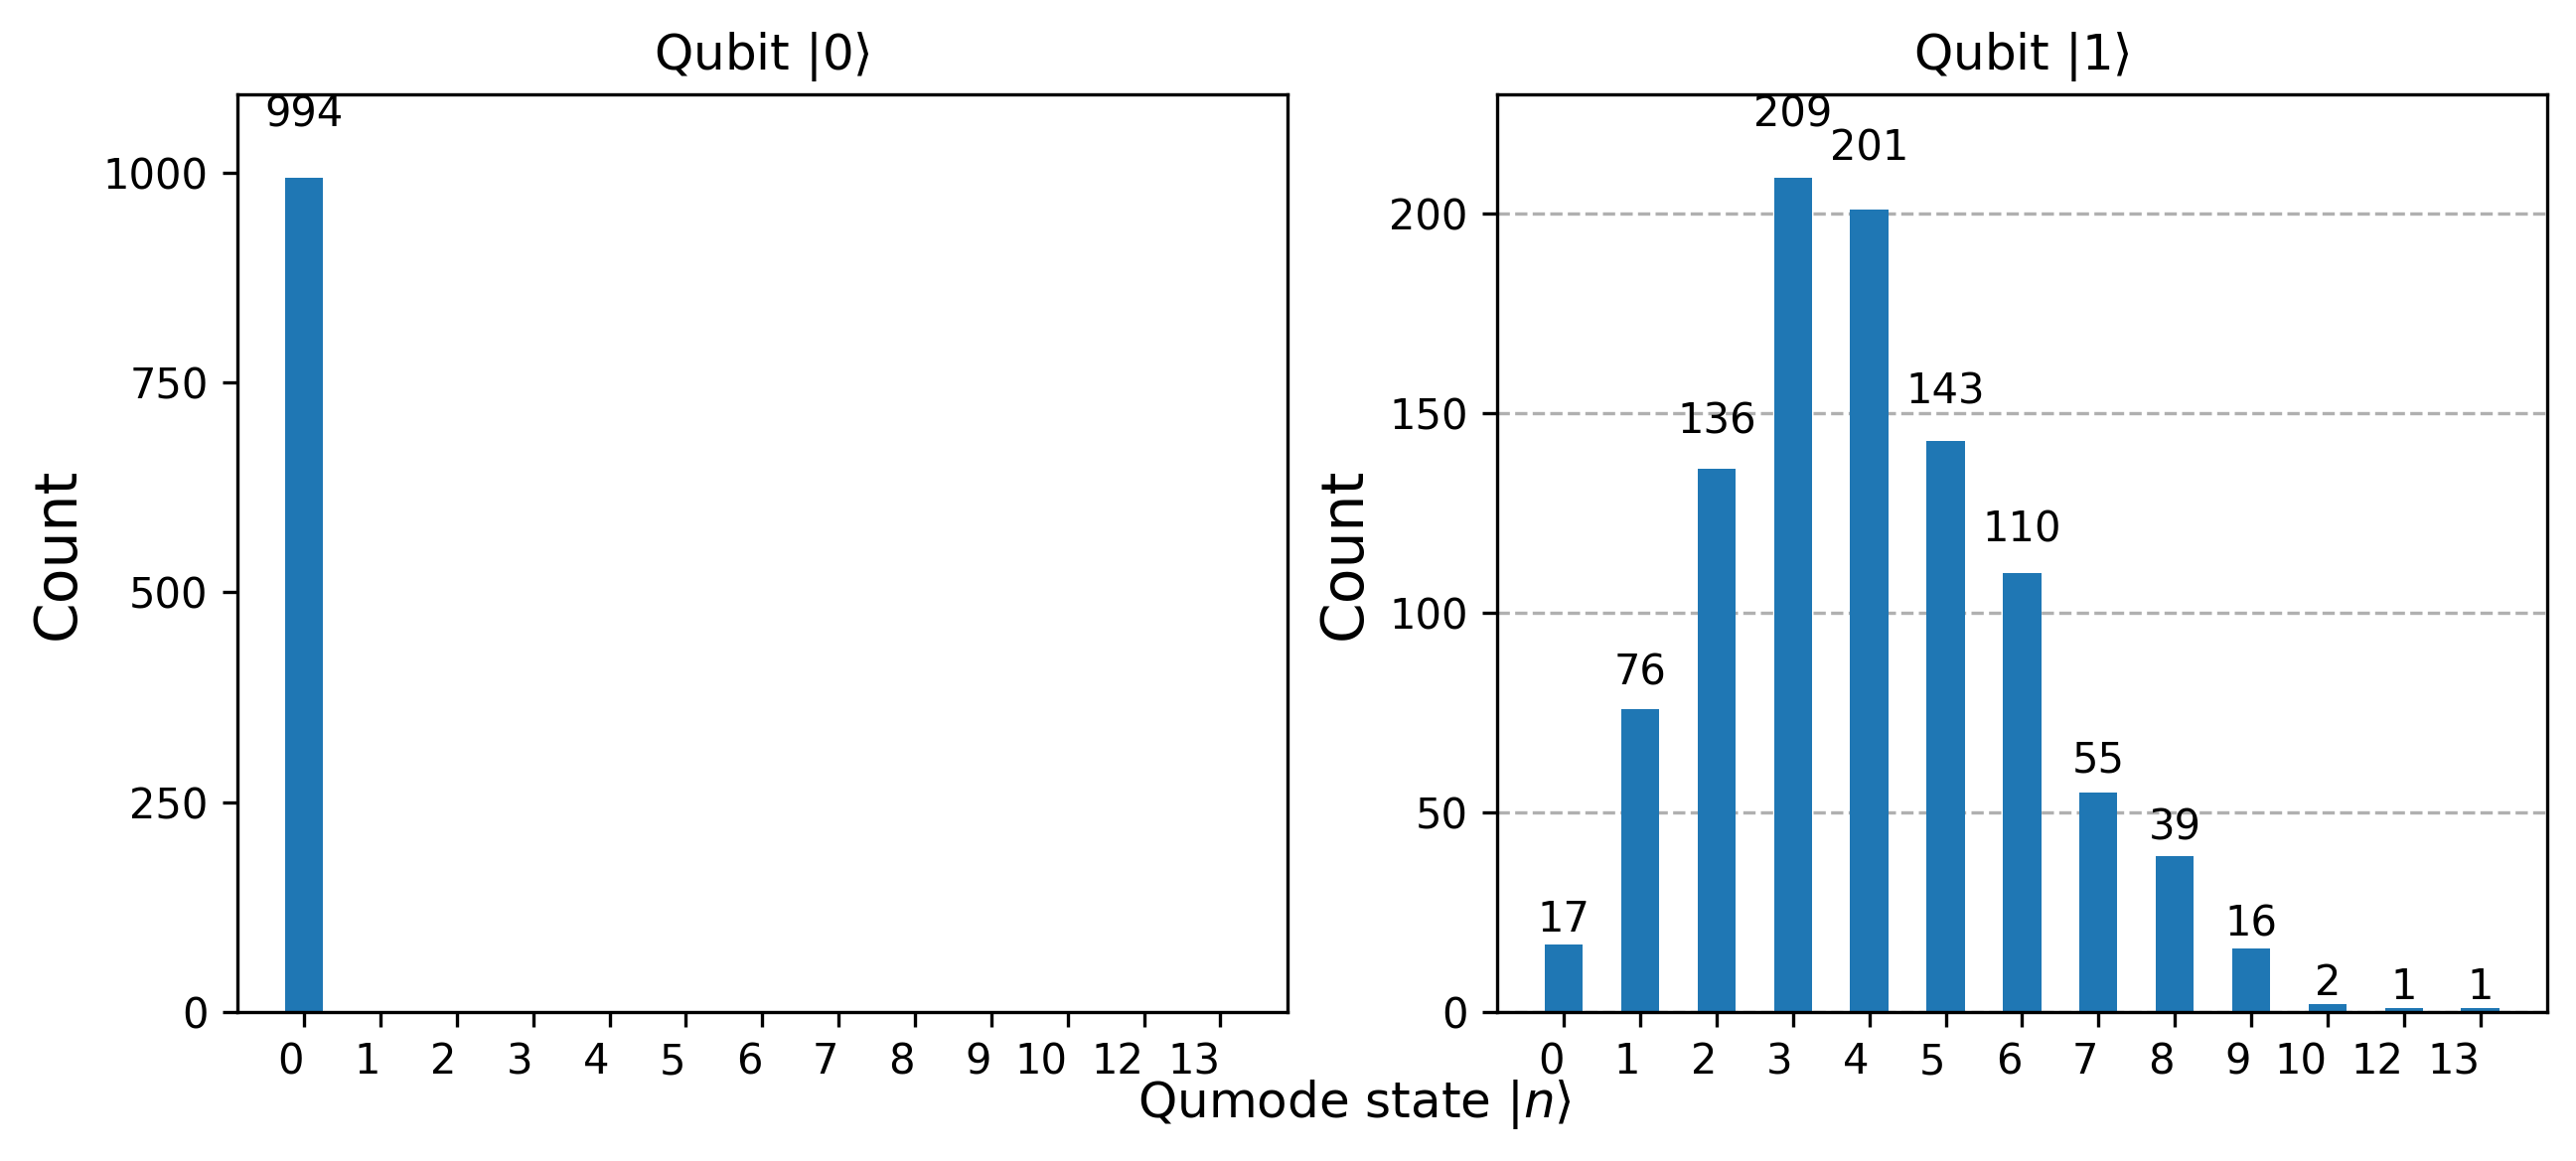

In [8]:
qubit0 = data.c_qubit.array.flat == 0
qumode_vacuum = data.c_qumode.slice_shots(qubit0)
qumode_coherent = data.c_qumode.slice_shots(~qubit0)

fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(10,4), dpi=300)
plot_histogram(ax=ax[0], data=qumode_vacuum.get_fock_counts())
ax[0].set_title(r'Qubit $|0\rangle$')
ax[0].tick_params('x', rotation=0)
plot_histogram(ax=ax[1], data=qumode_coherent.get_fock_counts())
ax[1].set_title(r'Qubit $|1\rangle$')
ax[1].tick_params('x', rotation=0)
fig.supxlabel('Qumode state $|n\\rangle$')
plt.show()

One can use the underlying data to calculate other quantities, e.g. the mean photon number $|\alpha|^2$ of the coherent state.

In [9]:
np.mean(qumode_coherent.array)

np.float64(4.0159045725646125)

### The odd-cycle game

Now consider playing the odd-cycle nonlocal game, which is one of the simplest graph coloring games available. In this nonlocal game, there are 2 players, Alice and Bob, who attempt to convince a referee that they have a valid 2-coloring of an odd-length cycle graph $G(n)$. The game proceeds by the referee independently (and simultaneously) asking the players each either a vertex question or an edge question, and the players must respond with a color assignment satisfying the rules:

- For a **vertex question**, the colors given by the players must match. $x = (v, v) \implies c_a = c_b$
- For an **edge question**, the colors must differ. $x = (v, v+1\mod n) \implies c_a \neq c_b$

An important caveat that makes this a nonlocal game is Alice and Bob may not communicate to coordinate their answers. However, sharing an entangled quantum state, specifically a Bell pair, and using appropriate measurements enables them to correlate their answers more often than any possible classical strategy, yielding a quantum advantage. The optimal classical strategy has win rate $\omega_c(n) = 1 - 1/(2n)$ while the optimal quantum strategy has win rate $\omega_q(n) = \cos^2[\pi/(4n)]$.

Drmota et al. (PRL 134, 070201, 2025) give a recent experimental demonstration of this game on discrete quantum hardware and show quantum advantage up to $n=21$, after which their measured value dips below the classical threshold. Nonlocal games are sensitive to bit-flip errors - since $c_a, c_b \in \{0, 1\}$, any single bit flip means the round is lost (technically a weight-2 X-type error results in them winning again). 

### Bosonic encodings

We're interested in seeing how well bosonic encodings of logical qubits can protect against noise, and we use the nonlocal game above as a target application - ideally, the use of error detection/correction will enable quantum advantage at higher $n$ as the quantum-classical separation disappears. As a simple model, we'll only concern ourselves with photon loss, the dominant error in superconduting cavities.

First we'll define a generic interface for all logical encodings.

In [10]:
Qumode = Iterable[Qubit]

class LogicalQubit(ABC):
    def __init__(self, *, fock_levels: int = None):
        self.fock_levels = fock_levels

    @property
    @abstractmethod
    def logical_0(self) -> List[float]:
        """Returns the logical |0> state as a statevector"""

    @property
    @abstractmethod
    def logical_1(self) -> List[float]:
        """Returns the logical |1> state as a statevector"""

    def setup(self, qc: bq.CVCircuit, kt: float):
        """Performs any necessary setup like adding ancillas"""
        self.kt = kt

        # Create a classical register to contain the result
        self.readout = qk.ClassicalRegister(self.num_logical_qubits(qc), name="c")
        qc.add_register(self.readout)

    def syndrome_extraction(self, qc: bq.CVCircuit, logical_qubits: List[Qumode]):
        """Performs the syndrome extraction on the logical qubit"""

    def decode_qubits(self, qc: bq.CVCircuit, logical_qubits: List[Qumode]):
        """Performs the decoder operation on the given logical qubit"""

    def has_error_syndrome(self, data: DataBin) -> NDArray:
        """Returns true/false if each shot had an error"""

    def get_error_free_counts(self, data: DataBin) -> Dict[str, int]:
        """Returns a count dictionary for samples that had no syndrome error"""

        # Default implementation assumes every shot has no error
        mask = self.has_error_syndrome(data)
        idx = np.nonzero(~mask)[0]
        return data[self.readout.name].slice_shots(idx).get_counts()

    def num_logical_qubits(self, qc: bq.CVCircuit):
        """The number of logical qubits in the circuit"""

        return sum(qmr.num_qumodes for qmr in qc.qmregs)

    def get_bell_state(self) -> list[float]:
        """Return the bell state |01> + |10>"""

        return (
            1
            / np.sqrt(2)
            * (
                np.kron(self.logical_0, self.logical_1)
                + np.kron(self.logical_1, self.logical_0)
            )
        )

**Unencoded state** In the simplest setup, the players may just use the $\ket{0}$ and $\ket{1}$ states of qumodes as qubits. This doesn't take advantage of the redudancy in the infinite hilbert space available.

In [11]:
class UnencodedQubit(LogicalQubit):
    @property
    def logical_0(self):
        v = np.zeros(self.fock_levels, dtype=np.complex128)
        v[0] = 1
        return v

    @property
    def logical_1(self):
        v = np.zeros(self.fock_levels, dtype=np.complex128)
        v[1] = 1
        return v

    def decode_qubits(self, qc, logical_qubits):
        for i, lq in enumerate(logical_qubits):
            qc.measure(lq[0], self.readout[i])

    def has_error_syndrome(self, data):
        shots = data[self.readout.name].num_shots
        return np.zeros(shots, dtype=bool)

    def __str__(self):
        return "Unencoded"

**Binomial code** There is a great notebook about this code in the tutorials folder (see `bosonic-kitten-code`). The logical states are $\ket{0_L} = \frac{\ket{0} + \ket{4}}{\sqrt{2}}$ and $\ket{1_L} = \ket{2}$. Syndrome checks are performed using parity checks, and we postprocess the data to discard all shots where a photon loss was detected. In the event of no error, we perform a correction to the state to counteract the no-jump backaction as explained in the other tutorial.

In [12]:
class BinomialQubit(LogicalQubit):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        if self.fock_levels < 5:
            raise ValueError("Need at least 5 levels to encode the 0-2-4 code")

        self._ud = self._decoder_unitary()

    @property
    def logical_0(self):
        v = np.zeros(self.fock_levels, dtype=np.complex128)
        v[[0, 4]] = 1 / np.sqrt(2)
        return v

    @property
    def logical_1(self):
        v = np.zeros(self.fock_levels, dtype=np.complex128)
        v[2] = 1
        return v

    def setup(self, qc, kt):
        self.kt = kt

        logical_qubits = []
        for qmr in qc.qmregs:
            logical_qubits.extend(qmr)

        self.readouts = [
            qk.ClassicalRegister(len(mode), name=f"c{i}")
            for i, mode in enumerate(logical_qubits)
        ]
        self.ancillas = qk.QuantumRegister(self.num_logical_qubits(qc))
        self.syndromes = qk.ClassicalRegister(self.ancillas.size, name="syndrome")

        for reg in self.readouts:
            qc.add_register(reg)

        qc.add_register(self.ancillas)
        qc.add_register(self.syndromes)

    def syndrome_extraction(self, qc, logical_qubits):
        for i, lq in enumerate(logical_qubits):
            # Implements photon number parity check, as seen in `bosonic-kitten-code.ipynb`
            qc.h(self.ancillas[i])
            qc.cv_c_r(np.pi / 2, lq, self.ancillas[i], duration=0)
            qc.cv_r(-np.pi / 2, lq, duration=0)
            qc.h(self.ancillas[i])
            qc.measure(self.ancillas[i], self.syndromes[i])

            # If we measure no photon loss, perform the correction on the logical 0 state
            with qc.if_test((self.syndromes[i], 0)) as else_:
                qc.cv_gate_from_matrix(
                    self._get_no_photon_correction(self.kt), lq, duration=0
                )
            with else_:
                qc.cv_gate_from_matrix(np.eye(self.fock_levels), lq, duration=0)

    def decode_qubits(self, qc, logical_qubits):
        for i, lq in enumerate(logical_qubits):
            qc.cv_gate_from_matrix(self._ud, lq, label="decode", duration=0)
            qc.cv_measure(lq, self.readouts[i])

    def get_error_free_counts(self, data):
        mask = self.has_error_syndrome(data)
        idx = np.nonzero(~mask)[0]

        counts = Counter()
        for i in idx:
            bitstring = ""
            for creg in reversed(self.readouts):
                state = (data[creg.name].array[i]).item()
                bitstring += "0" if state == 0 else "1"

            counts[bitstring] += 1

        return counts

    def has_error_syndrome(self, data):
        readouts = set(data) - {"syndrome"}
        result: NDArray = data.syndrome.array.flat != 0

        # If we measure state |2> or higher, that's also an error, except for state
        # |4> which is produced by the no-jump backaction on state |0L>
        for creg in readouts:
            result = result | ((data[creg].array.flat > 1))

        return result

    def _decoder_unitary(self) -> np.ndarray:
        empty = np.zeros((self.fock_levels, self.fock_levels), dtype=np.complex128)

        # Map our logical levels (|0> + |4>) -> |0>, |2> -> |1>
        ud = bq.util.fockmap(empty, [0, 4], 0, 1 / np.sqrt(2) * np.array([1, 1]))
        ud = bq.util.fockmap(ud, 2, 1)

        # Make unitary
        ud = bq.util.fockmap(ud, [0, 4], 4, 1 / np.sqrt(2) * np.array([1, -1]))
        ud = bq.util.fockmap(ud, 1, 2)
        remaining = [3] + list(range(5, self.fock_levels))
        ud = bq.util.fockmap(ud, remaining, remaining)
        return ud

    def _get_no_photon_correction(self, kt: float) -> np.ndarray:
        empty = np.zeros((self.fock_levels, self.fock_levels), dtype=np.complex128)
        # Map logical 1 back to logical 1
        u_even = bq.util.fockmap(empty, 2, 2)

        # Map logical 0's error state to logical 0
        u_even = bq.util.fockmap(
            u_even,
            [0, 0, 4, 4],
            [0, 4, 0, 4],
            1 / np.sqrt(1 + kt**2) * np.array([1, kt, -kt, 1]),
        )

        # Mappings to satisfy unitary condition
        remaining = list(set(range(self.fock_levels)) - {0, 2, 4})
        u_even = bq.util.fockmap(u_even, remaining, remaining)
        return u_even

    def __str__(self):
        return "Binomial"


**Cat state** Coherent states $\ket{\alpha}$ provide protection against this, as they are immune to photon loss ($a\ket{\alpha} = \alpha\ket{\alpha}$). Following the design of the Amazon Ocelot chip by Putterman et al. (Nature 638, 2025), define the cat state $\ket{C_\alpha^\pm} = \frac{\ket{+\alpha} \pm \ket{-\alpha}}{\sqrt{2(1 \pm e^{-2|\alpha|^2})}}$. The logical states are then given by
$$\ket{0_L} = \frac{1}{\sqrt{2}}(\ket{C_\alpha^+} + \ket{C_\alpha^-}) \approx \ket{+\alpha}$$
$$\ket{1_L} = \frac{1}{\sqrt{2}}(\ket{C_\alpha^+} - \ket{C_\alpha^-}) \approx \ket{-\alpha}$$
where the approximations hold in the large $|\alpha|^2$ limit. As photon loss errors change the parity of the even/odd cat states $a\ket{C_\alpha^\pm} = \pm\alpha\ket{C_\alpha^\mp}$, photon loss behaves like a Z-type error on the logical states. In the context of the nonlocal game, we are primarily concerned with bit flip errors (X-type), so we expect this logical encoding to improve the win rate of a quantum strategy.

Putterman et al. give a procedure to perform single-shot Z-basis measurement of the logical qubits. First, one displaces the qubit by $D(\pm\alpha)\ket{\psi}$, putting one of the logical states at the vacuum state $\ket{0}$. Then, through use of an ancilla qubit, detect if the logical qubit is in the vacuum state. This can be performed with the selective qubit rotation (SQR) gate conditioned on the cavity state. In detail, starting with the state $\ket{\psi_L}\ket{0}$, we perform the displacement (taking large $\alpha$)
$$D(\alpha)_B\ket{\psi_L}\ket{0} \rightarrow c_0 \ket{2\alpha}\ket{0} + c_1\ket{0}\ket{0}$$

Next, to detect the phase kick of the SQR gate, we put the ancilla into the $\ket{+}$ state with a Hadamard gate
$$H_a(c_0 \ket{2\alpha}\ket{0} + c_1\ket{0}\ket{0}) \rightarrow c_0 \ket{2\alpha}\ket{+} + c_1\ket{0}\ket{+}$$

To detect the vacuum state, we use the gate $SQR(\pi, \pi/2) = \ket{0}\bra{0} \otimes R_y(\pi)$ followed by another hadamard. 
$$H_QSQR(\pi, \pi/2)(c_0 \ket{2\alpha}\ket{+} + c_1\ket{0}\ket{+})\\ \rightarrow c_0\ket{2\alpha}\ket{0} - c_1\ket{0}\ket{1}$$

Finally, we can measure the ancilla qubit in the computational basis.

In [13]:
class CatQubit(LogicalQubit):
    def __init__(self, alpha: complex, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    @property
    def logical_0(self):
        return 1 / np.sqrt(2) * (self._cat_state("+") + self._cat_state("-"))

    @property
    def logical_1(self):
        return 1 / np.sqrt(2) * (self._cat_state("+") - self._cat_state("-"))

    def setup(self, qc, kt):
        super().setup(qc, kt)

        # Create one ancilla qubit per logical qubit
        self.ancillas = qk.QuantumRegister(self.num_logical_qubits(qc), name="a")
        qc.add_qubit_register(self.ancillas)

    def syndrome_extraction(self, qc, logical_qubits):
        # todo: idk how syndrome extraction works for this type of logical qubit.
        # it should be immune to photon loss, and the only degradation would come from
        # the no-jump kickback, requiring the system to pump more photons
        pass

    def decode_qubits(self, qc, logical_qubits):
        for i, lq in enumerate(logical_qubits):
            # Put the logical 1 state into the vacuum, then use the ancilla to identify
            # if the qumode is in the vacuum state with SQR gate
            qc.cv_d(self.alpha, lq, duration=0)
            ancilla = self.ancillas[i]
            qc.h(ancilla)
            qc.cv_snap(np.pi / 2, 0, lq, qubit=ancilla, duration=0)
            qc.h(ancilla)
            qc.measure(ancilla, self.readout[i])

    def has_error_syndrome(self, data):
        shots = data[self.readout.name].num_shots
        return np.zeros(shots, dtype=bool)

    def _coherent_state(self, alpha: complex):
        n = np.arange(self.fock_levels)
        alphas = alpha**n
        n_factorial = ssp.factorial(n)
        return np.exp(-np.abs(alpha) ** 2 / 2) * alphas / np.sqrt(n_factorial)

    @functools.cache
    def _cat_state(self, which="+"):
        if not which in {"+", "-"}:
            raise ValueError("Invalid sign")

        factor = 1 if which == "+" else -1
        norm = np.sqrt(2 * (1 + factor * np.exp(-2 * np.abs(self.alpha) ** 2)))
        return (
            self._coherent_state(self.alpha)
            + factor * self._coherent_state(-self.alpha)
        ) / norm

    def __str__(self):
        alpha2 = np.abs(self.alpha) ** 2
        return f"Cat $|\\alpha|^2$={alpha2:.2}"

### Simulation

With all of the QEC definitions, we can now write the simulation routine. It begins with preparing the bell state $\ket{\psi} = \frac{1}{\sqrt{2}}(\ket{0_L1_L} + \ket{1_L0_L})$, which we assume to be error-free for simplicity. Then, we apply a delay gate of time $t$ to create the error channel. Finally, we perform syndrome extraction and logical measurement, again assuming to be error-free and taking 0 time.

To calculate the "error rate" (the probability that a weight-1 error occured), we discard all samples where error syndromes were detected, and then determine the probability $P(c_a = c_b)$. Note that this syndrome detection only applies for the binomial code, as the individual cat qubits don't have a syndrome.

In [14]:
# Define how many qumodes we want, and how many qubits we should use to represent each.
# Our basis will consist of Fock states |0> to |15>. We use 2 qumodes, one for Alice and
# one for Bob.
num_qumodes = 2
num_fock_states = 16
num_qubits_per_qumode = math.ceil(math.log2(num_fock_states))


def prepare_circuit(qc: bq.CVCircuit, noise_pass=None):
    # Transpile to aer simulator with noise pass
    backend = AerSimulator()

    qc_compiled = qc
    if noise_pass is not None:
        qc_compiled = noise_pass(qc)

    return qk.transpile(qc_compiled, backend=backend)


def run_circuit(
    state: LogicalQubit,
    t: float = 1,
    unit: str = "ns",
    photon_loss_rate: float = 0.5,
    shots=10000,
):
    logical_qubits = bq.QumodeRegister(num_qumodes, num_qubits_per_qumode)
    qc = bq.CVCircuit(logical_qubits)
    state.setup(qc, photon_loss_rate * t)

    bell_state = state.get_bell_state()
    qc.cv_initialize(bell_state, logical_qubits, mode="full")
    for qumode in logical_qubits:
        qc.cv_delay(t, qumode, unit=unit)

    state.syndrome_extraction(qc, logical_qubits)
    state.decode_qubits(qc, logical_qubits)

    noise_pass = bq.kraus.PhotonLossNoisePass(
        photon_loss_rates=photon_loss_rate,
        circuit=qc,
        time_unit=unit,
        qumodes=logical_qubits[:],
    )
    qc_compiled = prepare_circuit(qc, noise_pass=noise_pass)
    sampler = FockSampler(AerSampler(default_shots=shots))
    job = sampler.run([qc_compiled])
    result = job.result()[0]

    good_counts = state.get_error_free_counts(result.data)
    good_shots = sum(good_counts.values())
    discard_rate = 1 - good_shots / shots
    error_rate = 1 - (good_counts["01"] + good_counts["10"]) / good_shots

    return error_rate, discard_rate

In [15]:
import warnings
warnings.filterwarnings('ignore', message=".*")


states = [
    UnencodedQubit(fock_levels=num_fock_states),
    BinomialQubit(fock_levels=num_fock_states),
    CatQubit(alpha=np.sqrt(0.5), fock_levels=num_fock_states),
    CatQubit(alpha=1.0, fock_levels=num_fock_states),
    CatQubit(alpha=np.sqrt(2), fock_levels=num_fock_states),
]

unit = "us"
photon_loss_rate = 0.5  # events/time

t_vals = np.linspace(0, 1, 21)
curves = OrderedDict()
for state in states:
    error_rates = []
    discard_rates = []
    for t in t_vals:
        error, discard = run_circuit(state, t=t, unit=unit, photon_loss_rate=photon_loss_rate)
        error_rates.append(error)
        discard_rates.append(discard)
    
    curves[state] = (error_rates, discard_rates)

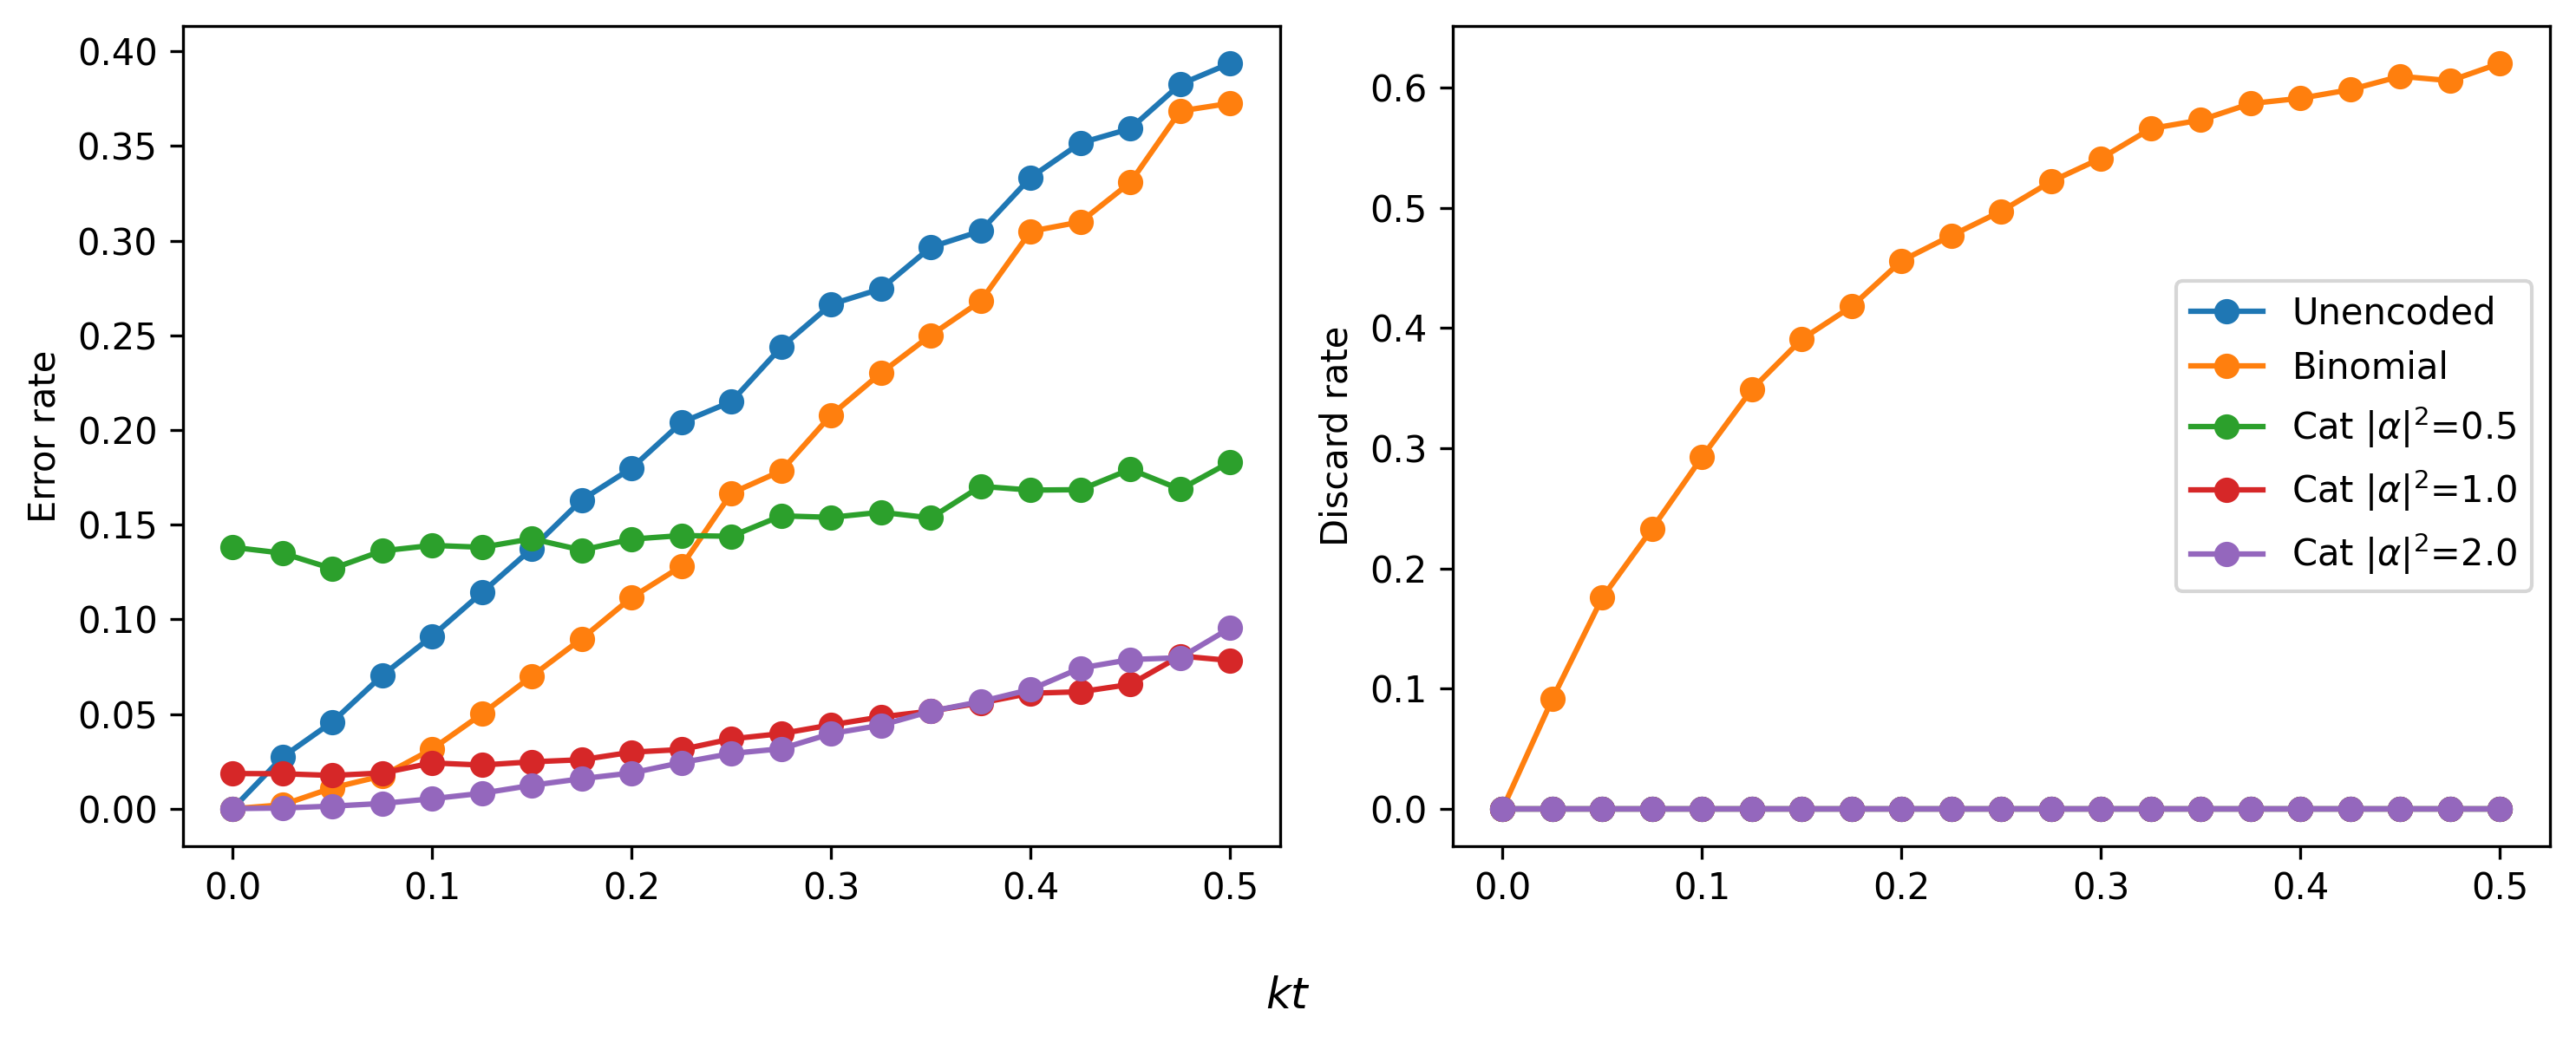

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, dpi=300)
for i, (state, f_vals) in enumerate(curves.items()):
    error_rates, discard_rates = f_vals
    label = str(state)
    ax[0].errorbar(t_vals * photon_loss_rate, error_rates, fmt='-o', color=f"C{i}", label=label)
    ax[0].set_ylabel("Error rate")
    ax[1].errorbar(t_vals * photon_loss_rate, discard_rates, fmt='-o', color=f"C{i}", label=label)
    ax[1].set_ylabel("Discard rate")

fig.supxlabel(f"$kt$")
plt.legend()
plt.tight_layout()
plt.show()

As error correction only works for small error scales $kt$, we choose $kt \approx 0.1$ and get the error rates $\epsilon_L$. (Is this true, should we be arbitrarily choosing $kt$?). Then, as a proxy for playing the full game, we estimate a "win rate" $\omega(n) = \omega_q(n)(1 - \epsilon_L)$.

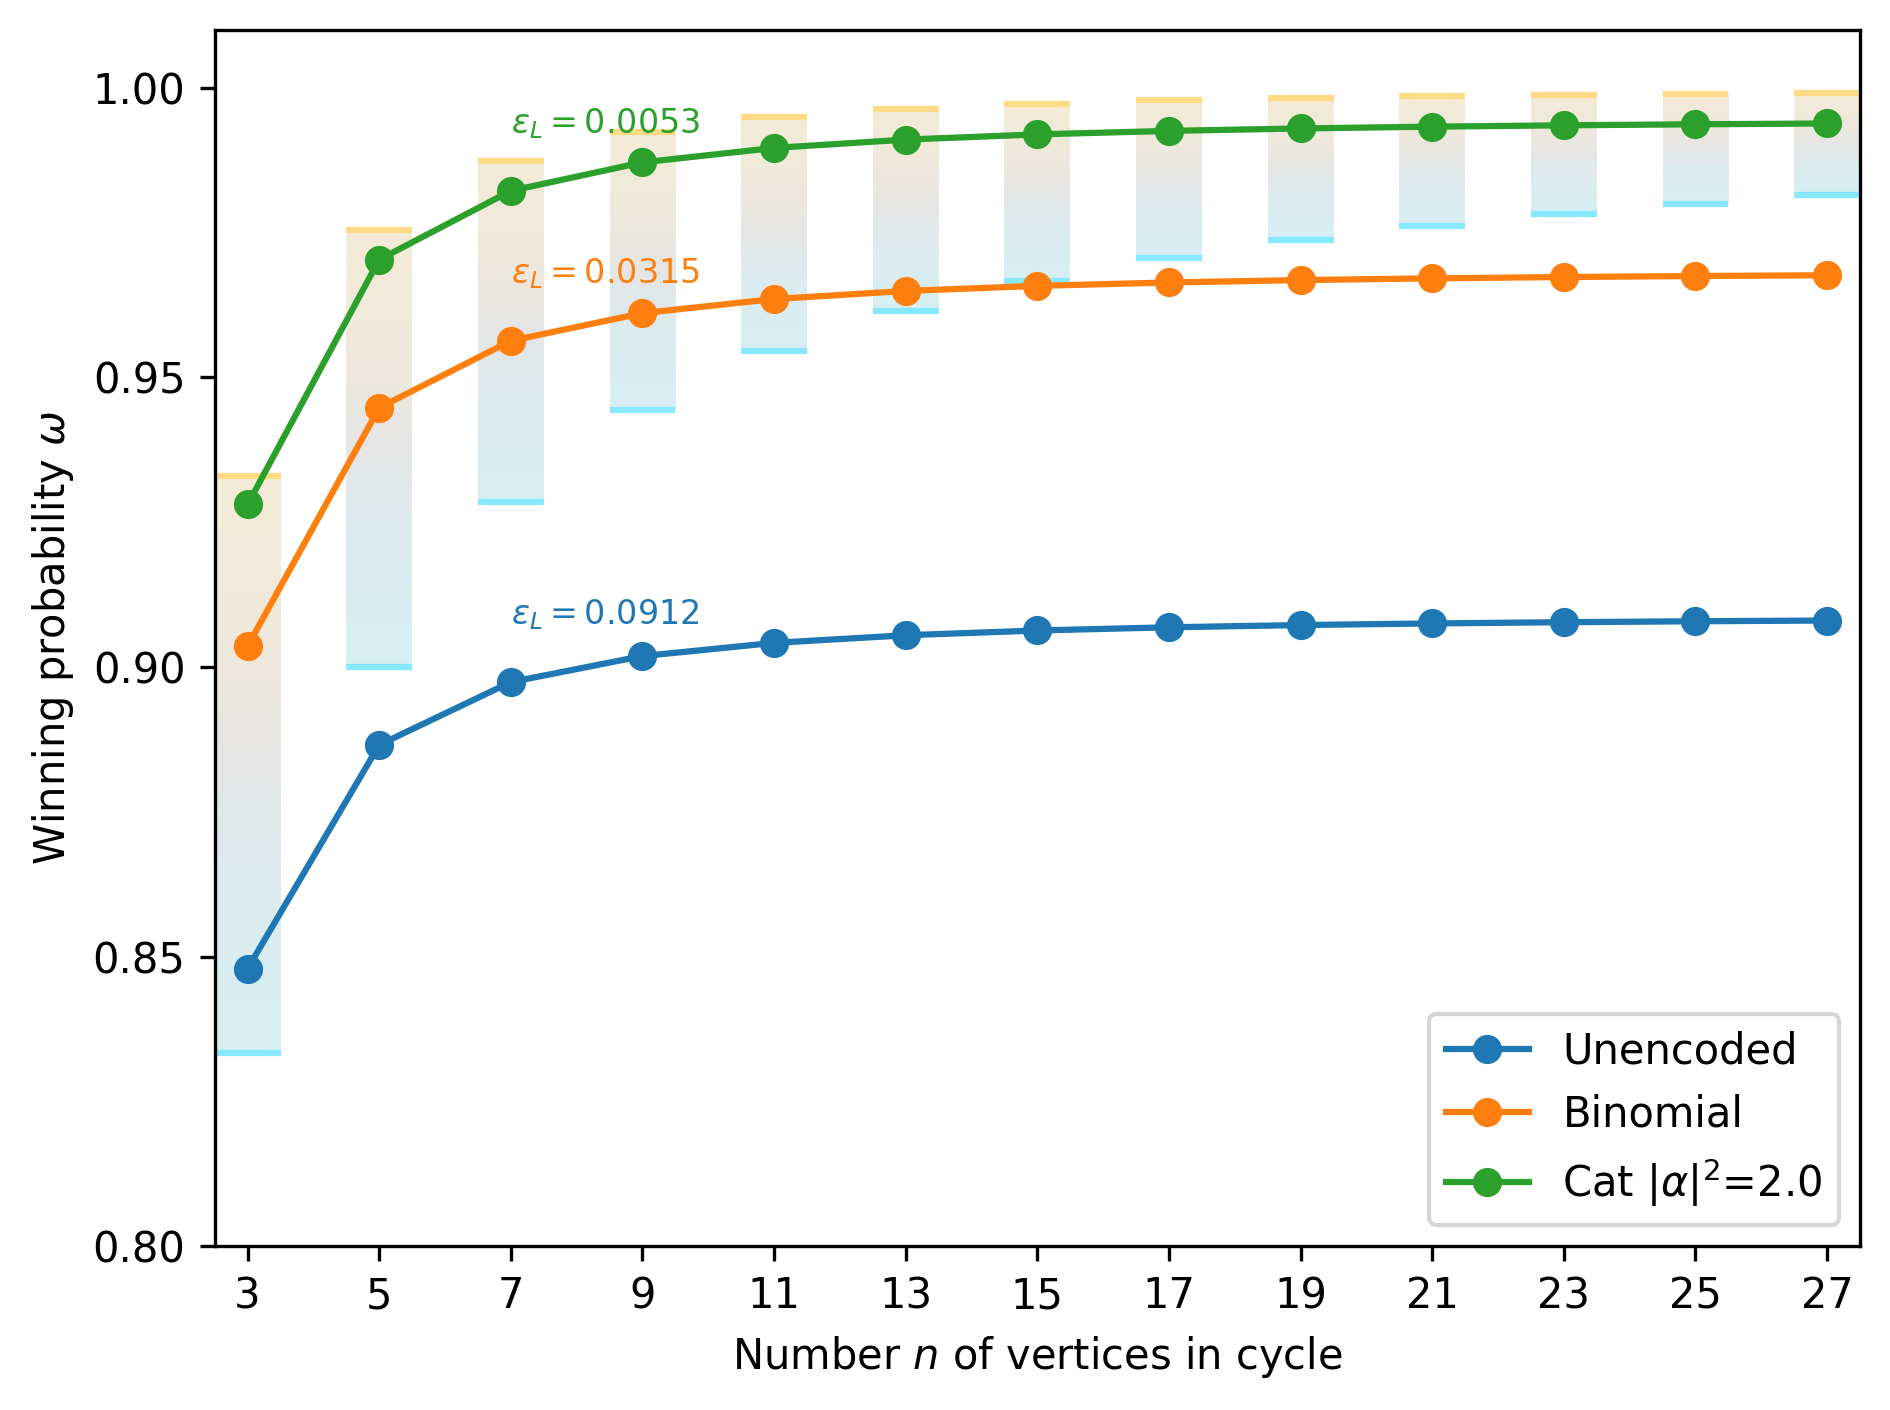

In [17]:
n = np.arange(3, 29, 2)  # odd cycle number
wc = 1 - 1 / (2 * n)
wq = np.cos(np.pi / (4 * n)) ** 2

fig = plt.figure(dpi=300)
ax = plt.gca()

# Draw the quantum/classical regions
colors = ["#78daf0", "#dddddd", "#f0d078"]
hue_sat = [(191/360, 0.6), (0, 0), (42/360, 0.6)]
lightness = 0.9
colors = [colorsys.hls_to_rgb(h, lightness, s) for h, s in hue_sat]
cmap = LinearSegmentedColormap.from_list("hsl_colormap", colors, N=256)

gradient_bar(ax, n - 0.5, wc, wq, cmap=cmap, width=1)
for i in range(len(n)):
    hue, saturation = hue_sat[0]
    c = colorsys.hls_to_rgb(hue, lightness * 0.85, 1.0)
    plt.hlines(wc[i], n[i] - 0.5, n[i] + 0.5, colors=c)
    hue, saturation = hue_sat[-1]
    c = colorsys.hls_to_rgb(hue, lightness * 0.85, 1.0)
    plt.hlines(wq[i], n[i] - 0.5, n[i] + 0.5, colors=c)

# Now plot the trajectories for each QEC code, taking only some to avoid cluttering the plot
to_draw = [states[0], states[1], states[-1]]
for i, state in enumerate(to_draw):
    error_rates, discard_rates = curves[state]
    error_rate = error_rates[4]
    plt.errorbar(n, wq * (1 - error_rate), fmt="-o", color=f"C{i}", label=str(state))
    plt.text(
        7,
        wq[2] * (1 - error_rate) + 0.01,
        f"$\\epsilon_L = {error_rate:.4f}$",
        color=f"C{i}",
        size=8
    )

plt.xticks(n)
plt.xlabel("Number $n$ of vertices in cycle")
plt.ylabel("Winning probability $\\omega$")
plt.ylim(0.8, 1.01)
plt.yticks(np.arange(0.8, 1.05, 0.05))
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

As expected, more protection leads to quantum advantage at higher $n$, and at least under our very simplified simulation, bosonic QEC codes can provide extra utility over naive encodings of data.